In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# Read the CSV file
df = pd.read_csv('experiment_results.csv')

# remove null columns
df = df.dropna(axis=1, how='all')

# Display basic information about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   experiment_name             123 non-null    object 
 1   video_name                  123 non-null    object 
 2   resolution                  123 non-null    object 
 3   square_size                 123 non-null    int64  
 4   to_remove                   123 non-null    float64
 5   alpha                       123 non-null    float64
 6   bitrate                     123 non-null    int64  
 7   server_runtime              123 non-null    int64  
 8   client_runtime              123 non-null    int64  
 9   smoothing_factor            123 non-null    float64
 10  hnerv_ks                    93 non-null     object 
 11  hnerv_enc_strds             93 non-null     object 
 12  hnerv_enc_dim               93 non-null     object 
 13  hnerv_fc_hw                 93 non-

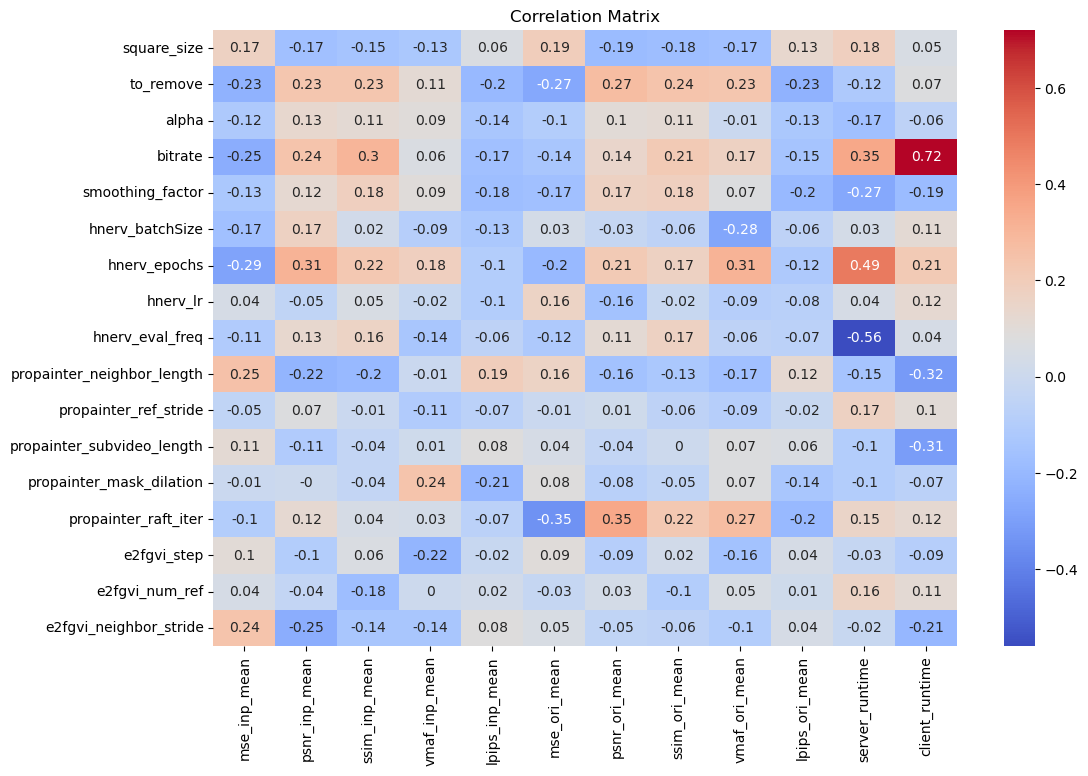

In [61]:
# Define the list of known quality metrics
quality_metrics = [
    'mse_inp_mean', 'psnr_inp_mean', 'ssim_inp_mean', 'vmaf_inp_mean', 'lpips_inp_mean',
    'mse_ori_mean', 'psnr_ori_mean', 'ssim_ori_mean', 'vmaf_ori_mean', 'lpips_ori_mean', 
    'server_runtime', 'client_runtime', 
]

# Identify parameters by excluding quality metrics and any non-numeric columns
parameters = [col for col in df.columns if col not in quality_metrics and pd.api.types.is_numeric_dtype(df[col])]


# Filter the data to keep only the relevant columns for correlation
relevant_data = df[parameters + quality_metrics]

# Correlation matrix to see how parameters are related
correlation_matrix = df.corr('spearman', numeric_only=True)

# Extract correlations between parameters and quality metrics
correlations_with_quality = correlation_matrix.loc[parameters, quality_metrics]
correlations_with_quality = correlations_with_quality.dropna()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(np.round(correlations_with_quality, 2), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

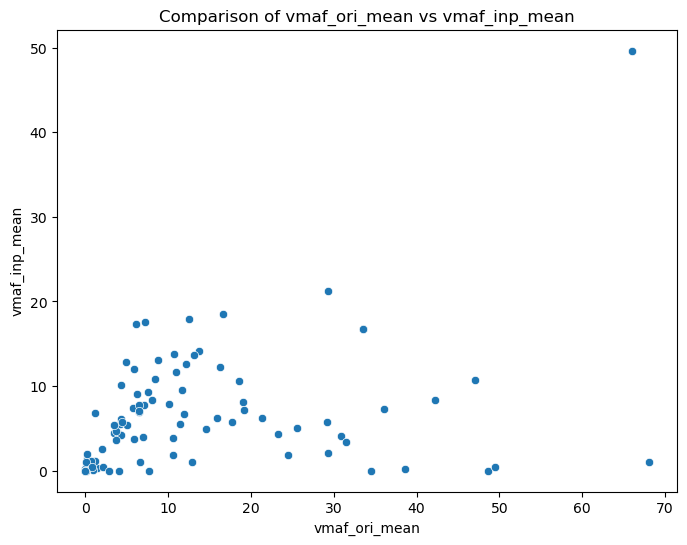

In [69]:
def filter_data(data, plot=False, **conditions):
    """
    Filters the dataset based on conditions provided for parameters.
    Optionally, plots either a correlation heatmap or a scatter plot for two specified columns.

    Parameters:
    data (pd.DataFrame): The dataset to filter.
    plot (bool or tuple): If True, generates a correlation heatmap for the filtered data.
                          If a tuple of two column names, generates a scatter plot of those columns.
    **conditions: Key-value pairs where the key is the parameter name, 
                  and the value is either a specific value or a tuple for a range.

    Returns:
    pd.DataFrame: Filtered subset of the data.
    """
    # Filter the data based on conditions
    filtered_data = data
    for parameter, value in conditions.items():
        if isinstance(value, tuple) and len(value) == 2:  # Range condition
            filtered_data = filtered_data[(filtered_data[parameter] >= value[0]) & (filtered_data[parameter] <= value[1])]
        else:  # Exact match condition
            filtered_data = filtered_data[filtered_data[parameter] == value]
    
    # Plot if plot argument is provided
    if plot:
        if plot is True:
            # Plot correlation heatmap for all numeric columns
            numeric_columns = filtered_data.select_dtypes(include=['float64', 'int64']).columns
            correlation_matrix = filtered_data[numeric_columns].corr()
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
            plt.title("Correlation Heatmap of Parameters and Quality Metrics")
            plt.show()
        
        elif isinstance(plot, tuple) and len(plot) == 2:
            col1, col2 = plot
            if col1 in filtered_data.columns and col2 in filtered_data.columns:
                # Scatter plot of the specified columns
                plt.figure(figsize=(8, 6))
                sns.scatterplot(x=filtered_data[col1], y=filtered_data[col2])
                plt.xlabel(col1)
                plt.ylabel(col2)
                plt.title(f"Comparison of {col1} vs {col2}")
                plt.show()
            else:
                print(f"Columns '{col1}' and/or '{col2}' not found in the dataset.")
    
    return filtered_data

# Filter and plot a scatter plot of 'alpha' vs 'psnr_inp_mean'
result = filter_data(df, hnerv_ks='0_3_3', plot=('vmaf_ori_mean', 'vmaf_inp_mean'))

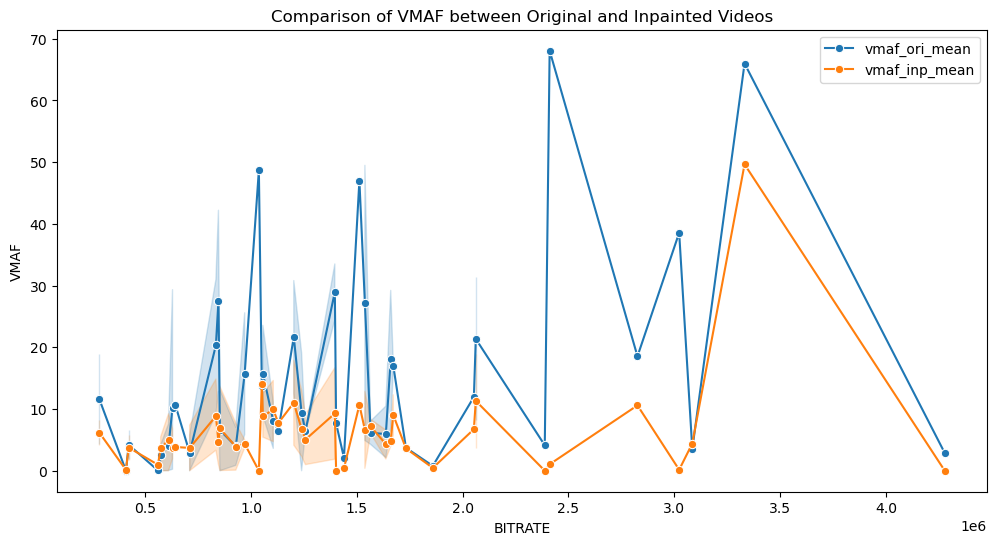

In [53]:
# Function to plot comparison between original and inpainted results
def plot_comparison(df, metric, parameter):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x=parameter, y=f'{metric}_ori_mean', label=f'{metric}_ori_mean', marker='o')
    sns.lineplot(data=df, x=parameter, y=f'{metric}_inp_mean', label=f'{metric}_inp_mean', marker='o')
    plt.title(f'Comparison of {metric.upper()} between Original and Inpainted Videos')
    plt.xlabel(parameter.upper())
    plt.ylabel(metric.upper())
    plt.legend()
    plt.show()

# Plot comparisons for each metric
metrics = ['vmaf'] # 'mse', 'psnr', 'ssim'
parameters = ['bitrate'] # 'video_name', 'scene_number', 'resolution', 'square_size', 'percentage_to_remove', 'alpha', 'neighbor_length', 'ref_stride', 'subvideo_length', 'bitrate', 'server_runtime', 'client_runtime'
for metric in metrics:
    for parameter in parameters:
        plot_comparison(df[df.hnerv_ks.notna()], metric, parameter)

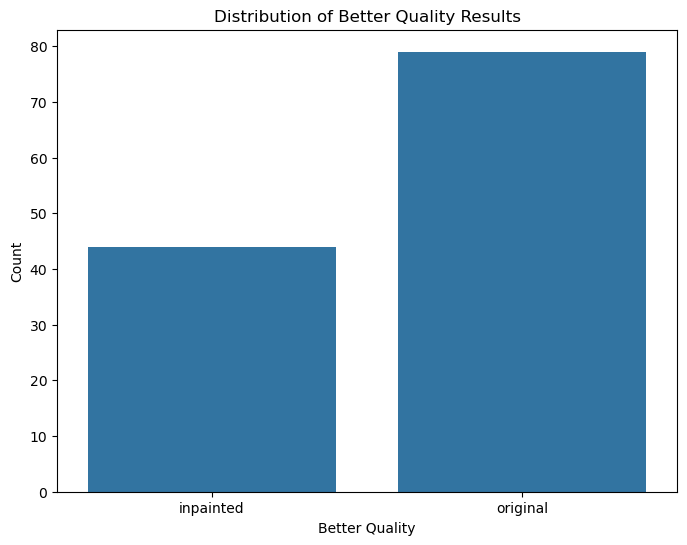

In [54]:
# Identify which scenes have better quality for original vs inpainted
df['better_quality'] = df.apply(lambda row: 'original' if row['vmaf_ori_mean'] > row['vmaf_inp_mean'] else 'inpainted', axis=1)

# Visualize the distribution of better quality results
plt.figure(figsize=(8, 6))
sns.countplot(x='better_quality', data=df)
plt.title('Distribution of Better Quality Results')
plt.xlabel('Better Quality')
plt.ylabel('Count')
plt.show()

In [82]:
# Define quality metrics and create columns for differences
quality_metrics = ['psnr_ori_mean', 'ssim_ori_mean', 'psnr_inp_mean', 'ssim_inp_mean']
differences = {}

# Calculate the differences between original and inpainted metrics
for metric in ['mse', 'psnr', 'ssim', 'vmaf', 'lpips']:
    differences[f'{metric}_diff'] = df[f'{metric}_inp_mean'] - df[f'{metric}_ori_mean']

# Create a table with experiment identifier, original and inpainted metrics, and differences
difference_table = df[['experiment_name'] + quality_metrics].copy()
difference_table = difference_table[difference_table.hnerv_ks.notna()]
for diff_name, diff_values in differences.items():
    difference_table[diff_name] = diff_values

# Display the table
print(difference_table)

# Visualize the distribution of quality results
plt.figure(figsize=(8, 6))
sns.scatterplot(x='experiment_name', y='vmaf_diff', data=difference_table)
plt.title('Distribution of Quality Results')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'hnerv_ks'